## HCP individualized connectome prediction

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
participants_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/HCP-YA_dataset/participants.tsv"
participants_df = pd.read_csv(participants_path, sep='\t')

In [3]:
participants_df.head()

,participant_id,subject,age,sex,train_val_test
0,sub-100206,100206,27,M,train
1,sub-100307,100307,27,F,train
2,sub-100408,100408,33,M,val
3,sub-100610,100610,27,M,train
4,sub-101006,101006,35,F,val


In [4]:
# Option to select either "Glasser" or "S456" parcellation
parcellation = "Glasser"  # options: "Glasser" or "S456"

if parcellation == "S456":
    # Use 4S456Parcels data
    sc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_SCifod2actvolnorm.mat"
    fc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_FCcorrhpf.mat"
elif parcellation == "Glasser":
    # Use Glasser data
    sc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_SCifod2actvolnorm.mat"
    fc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_FCcorrhpf.mat"
else:
    raise ValueError(f'Invalid parcellation: must be "Glasser" or "S456"')

# Load the structural connectivity (SC) .mat file
sc_mat = scipy.io.loadmat(sc_mat_path)

sc_subjects = sc_mat['subjects']
sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]

sc_cell = sc_mat['SC']
sc_cell = np.squeeze(sc_cell)  # Make 1D if needed
n_sc_subj = sc_cell.shape[0]
# Each element is nparcel x nparcel
sc_matrices = np.stack([sc_cell[i] for i in range(n_sc_subj)], axis=0)
sc_triangles = np.stack([square2tri(sc_matrices[i], k=1) for i in range(n_sc_subj)], axis=0)

# Load the functional connectivity (FC) .mat file
fc_mat = scipy.io.loadmat(fc_mat_path)

fc_subjects = fc_mat['subjects']
fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]

fc_cell = fc_mat['FC']
fc_cell = np.squeeze(fc_cell)  # Make 1D if needed
n_fc_subj = fc_cell.shape[0]
# Each element is nparcel x nparcel
fc_matrices = np.stack([fc_cell[i] for i in range(n_fc_subj)], axis=0)
fc_triangles = np.stack([square2tri(fc_matrices[i], k=1) for i in range(n_fc_subj)], axis=0)

/tmp/ipykernel_1679529/1198866335.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]


NameError: name 'square2tri' is not defined

In [ ]:
print("fc_subjects shape:", np.shape(fc_subjects))
print("fc_matrices shape:", fc_matrices.shape)
print("fc_triangles shape:", fc_triangles.shape, '\n')

print("sc_subjects shape:", np.shape(sc_subjects))
print("sc_matrices shape:", sc_matrices.shape)
print("sc_triangles shape:", sc_triangles.shape)


fc_subjects shape: (957,)
fc_matrices shape: (957, 360, 360)
fc_triangles shape: (957, 64620) 

sc_subjects shape: (957,)
sc_matrices shape: (957, 360, 360)
sc_triangles shape: (957, 64620)


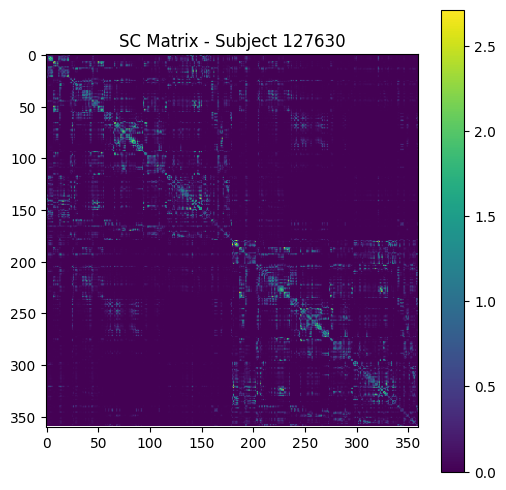

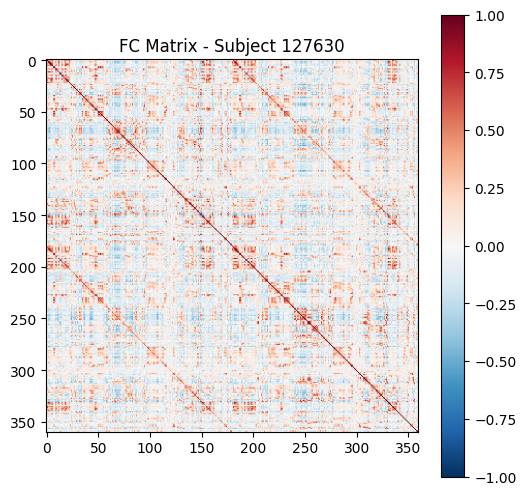

In [ ]:
import random
import matplotlib.pyplot as plt

# Pick a random subject index that is present in both SC and FC sets
common_subjects = list(set(sc_subjects) & set(fc_subjects))
if not common_subjects:
    raise ValueError("No subjects in common between SC and FC datasets.")

# Choose a random subject
rand_subject = random.choice(common_subjects)

# Find index of this subject in sc_subjects and fc_subjects
sc_idx = sc_subjects.index(rand_subject)
fc_idx = fc_subjects.index(rand_subject)

# Get the full matrices (not just triangles)
sc_matrix = sc_matrices[sc_idx]
fc_matrix = fc_matrices[fc_idx]

# Plot SC matrix (ensure image is square)
plt.figure(figsize=(6, 6))
plt.imshow(sc_matrix, aspect='equal', cmap='viridis')
plt.title(f"SC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()

# Plot FC matrix (ensure image is square) with colormap RdBu_r and colorbar from -1 to 1
plt.figure(figsize=(6, 6))
plt.imshow(fc_matrix, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title(f"FC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()


Data loader logic walk through

In [14]:
import importlib
import hcp_dataset
importlib.reload(hcp_dataset)
from hcp_dataset import *
from dataset_utils import *
from data_utils import *


In [15]:
HCP_Dataset = HCP_Dataset(parcellation="Glasser", HCP_dir="/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200/", shuffle_seed=0)

KeyError: 'subject'

In [ ]:
HCP_Dataset.metadata_df.head()

,subject,train_val_test,age,sex,Race_Ethnicity,Family_Relation,Family_ID
0,100206,train,27,M,White_Not Hispanic/Latino,NotTwin,56037_85858
1,100307,train,27,F,White_Not Hispanic/Latino,MZ,51488_81352
2,100408,val,33,M,White_Not Hispanic/Latino,MZ,51730_81594
3,100610,train,27,M,White_Not Hispanic/Latino,DZ,52813_82634
4,101006,val,35,F,Black or African Am._Not Hispanic/Latino,MZ,51283_52850_81149


In [12]:
HCP_Dataset.freesurfer_df.head()

,Subject,FS_IntraCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,FS_SubCort_GM_Vol,FS_Total_GM_Vol,...,FS_R_Rostralanteriorcingulate_Area,FS_R_Rostralmiddlefrontal_Area,FS_R_Superiorfrontal_Area,FS_R_Superiorparietal_Area,FS_R_Superiortemporal_Area,FS_R_Supramarginal_Area,FS_R_Frontalpole_Area,FS_R_Temporalpole_Area,FS_R_Transversetemporal_Area,FS_R_Insula_Area
0,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100206,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488.0,305634.0,610122.0,70240.0,807245.0,...,791.0,8627.0,8515.0,6315.0,4337.0,3522.0,356.0,500.0,384.0,2267.0
2,100307,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030.0,243207.0,483238.0,56623.0,664124.0,...,505.0,5702.0,6463.0,4538.0,3441.0,3613.0,257.0,412.0,375.0,2385.0
3,100408,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695.0,265243.0,525938.0,63869.0,726206.0,...,631.0,7092.0,7484.0,5367.0,3984.0,4144.0,298.0,410.0,421.0,2578.0
4,100610,1.816044e+06,1321362.0,1306929.0,1.304569e+06,276506.0,278002.0,554508.0,74869.0,762308.0,...,629.0,7027.0,7088.0,6820.0,3876.0,3730.0,298.0,393.0,337.0,2792.0


In [13]:
# Of the 957 metadata subjects, count how many have missing data in all columns for freesurfer
freesurfer_df = HCP_Dataset.freesurfer_df.copy()
metadata_df = HCP_Dataset.metadata_df.copy()

# Only keep freesurfer subjects that appear in the metadata subject list
# Use lowercase check to match subject columns robustly
meta_subj_col = None
for col in metadata_df.columns:
    if col.lower() == "subject":
        meta_subj_col = col
        break
fs_subj_col = None
for col in freesurfer_df.columns:
    if col.lower() == "subject":
        fs_subj_col = col
        break
if meta_subj_col is None or fs_subj_col is None:
    raise ValueError("Could not find 'subject' column in metadata or freesurfer df!")

# Subset freesurfer_df to only the subjects in metadata
meta_subject_ids = metadata_df[meta_subj_col].astype(str)
freesurfer_df = freesurfer_df[freesurfer_df[fs_subj_col].astype(str).isin(meta_subject_ids)].reset_index(drop=True)

# Find columns that are actual Freesurfer measurements (exclude Subject or any other ID columns)
fs_columns = [col for col in freesurfer_df.columns if col.lower() not in {'subject', 'subjectid', 'subject_id', 'id'}]

# For each subject, check if all of the FS columns are null (i.e., missing all measurements)
subjects_missing_all = freesurfer_df[freesurfer_df[fs_columns].isnull().all(axis=1)]

print(f"Number of subjects in metadata_df: {metadata_df.shape[0]}")
print(f"Number of subjects in freesurfer_df after subsetting: {freesurfer_df.shape[0]}")
print(f"Number of FS measurement columns: {len(fs_columns)}")
print(f"Number of subjects missing ALL FS measurements: {subjects_missing_all.shape[0]}")

if not subjects_missing_all.empty:
    print("Subjects missing all FS data (showing up to 5):")
    show_cols = []
    # Prefer a column that indicates subject id for display, fallback if no 'Subject'
    if 'Subject' in freesurfer_df.columns:
        show_cols.append('Subject')
    elif 'subject' in freesurfer_df.columns:
        show_cols.append('subject')
    else:
        show_cols.append(freesurfer_df.columns[0])
    # Just show first FS column for preview
    if len(fs_columns):
        show_cols.append(fs_columns[0])
    print(subjects_missing_all[show_cols].head())
else:
    print("No subjects are missing all FS measurements.")

Number of subjects in metadata_df: 957
Number of subjects in freesurfer_df after subsetting: 957
Number of FS measurement columns: 199
Number of subjects missing ALL FS measurements: 0
No subjects are missing all FS measurements.


In [123]:
# Plot average SC matrices for train, val, test splits using tri2square
sc_tri_indices = np.triu_indices(sc_matrices.shape[1], k=1)
sc_train_avg_mat = tri2square(HCP_Dataset.SC_train_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)
sc_val_avg_mat = tri2square(HCP_Dataset.SC_val_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)
sc_test_avg_mat = tri2square(HCP_Dataset.SC_test_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average SCs
from scipy.stats import pearsonr

def tri_corr(mat1, mat2):
    # extract upper triangle without diagonal, flatten
    iu = np.triu_indices_from(mat1, k=1)
    return pearsonr(mat1[iu], mat2[iu])[0]

print("SC Train vs Val Pearson r:", tri_corr(sc_train_avg_mat, sc_val_avg_mat))
print("SC Train vs Test Pearson r:", tri_corr(sc_train_avg_mat, sc_test_avg_mat))
print("SC Val vs Test Pearson r:", tri_corr(sc_val_avg_mat, sc_test_avg_mat))

# PLOT: imshow and histogram for each SC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
sc_avg_mats = [sc_train_avg_mat, sc_val_avg_mat, sc_test_avg_mat]
sc_titles = ["SC Train Average", "SC Val Average", "SC Test Average"]

for i, (mat, title) in enumerate(zip(sc_avg_mats, sc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='viridis')
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='steelblue', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()

# Plot average FC matrices for train, val, test splits using tri2square
fc_tri_indices = np.triu_indices(fc_matrices.shape[1], k=1)
fc_train_avg_mat = tri2square(HCP_Dataset.FC_train_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)
fc_val_avg_mat = tri2square(HCP_Dataset.FC_val_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)
fc_test_avg_mat = tri2square(HCP_Dataset.FC_test_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average FCs
print("FC Train vs Val Pearson r:", tri_corr(fc_train_avg_mat, fc_val_avg_mat))
print("FC Train vs Test Pearson r:", tri_corr(fc_train_avg_mat, fc_test_avg_mat))
print("FC Val vs Test Pearson r:", tri_corr(fc_val_avg_mat, fc_test_avg_mat))

# PLOT: imshow and histogram for each FC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
fc_avg_mats = [fc_train_avg_mat, fc_val_avg_mat, fc_test_avg_mat]
fc_titles = ["FC Train Average", "FC Val Average", "FC Test Average"]

for i, (mat, title) in enumerate(zip(fc_avg_mats, fc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='indianred', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()


AttributeError: 'HCP_Dataset' object has no attribute 'SC_train_avg'

### PCA info loss eval ()

In [ ]:
# has PCA wiped out the detailed signal we are trying to recover? 

In [13]:
# Assuming participants_df, sc_subjects, fc_subjects, sc_triangles, fc_triangles are defined

# Get lists of subjects for train/val/test according to participants_df
train_subjects = participants_df[participants_df["train_val_test"] == "train"]["subject"].tolist()
val_subjects = participants_df[participants_df["train_val_test"] == "val"]["subject"].tolist()
test_subjects = participants_df[participants_df["train_val_test"] == "test"]["subject"].tolist()

# Utility function to find indices in subject list
def subject_indices(subject_list, target_subjects):
    return [i for i, subj in enumerate(subject_list) if subj in target_subjects]

# SC: use sc_subjects (guaranteed order) and sc_triangles
sc_train_indices = subject_indices(sc_subjects, train_subjects)
SC_train_np = sc_triangles[sc_train_indices]
SC_train = torch.tensor(SC_train_np, dtype=torch.float32)

# FC: use fc_subjects (guaranteed order) and fc_triangles
fc_train_indices = subject_indices(fc_subjects, train_subjects)
fc_val_indices = subject_indices(fc_subjects, val_subjects)
fc_test_indices = subject_indices(fc_subjects, test_subjects)

FC_train_np = fc_triangles[fc_train_indices]
FC_val_np = fc_triangles[fc_val_indices]
FC_test_np = fc_triangles[fc_test_indices]

FC_train = torch.tensor(FC_train_np, dtype=torch.float32)
FC_val = torch.tensor(FC_val_np, dtype=torch.float32)
FC_test = torch.tensor(FC_test_np, dtype=torch.float32)


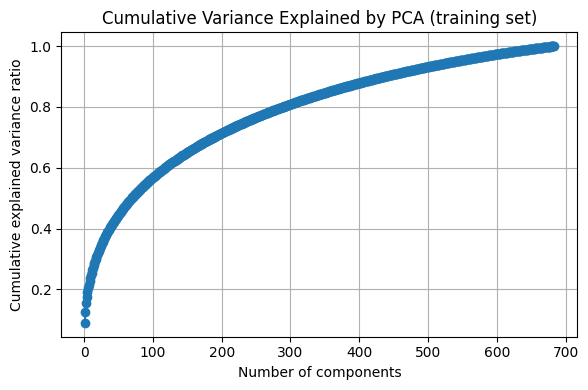

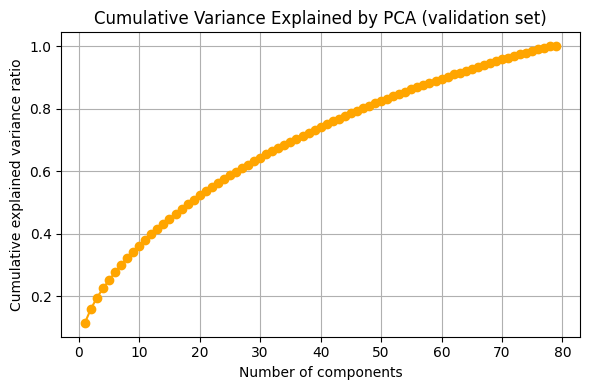

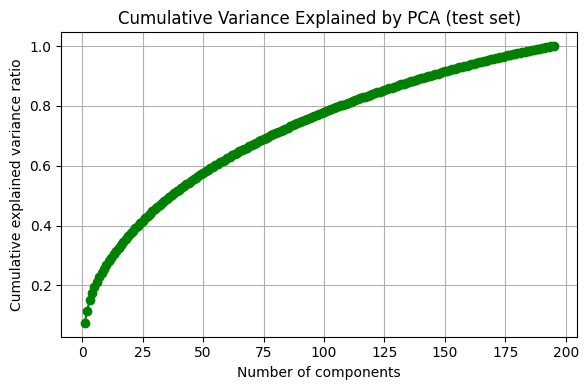

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Make numpy arrays, if not already
X_train = SC_train_np           # shape: (n_samples, n_features)
Y_train = FC_train_np           # shape: (n_samples, n_features)
Y_val = FC_val_np               # shape: (n_val_samples, n_features)

# Fit PCA on the training set
pca_train = PCA()
pca_train.fit(Y_train)

# Plot cumulative explained variance ratio for training set
cumvar_train = np.cumsum(pca_train.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(cumvar_train) + 1), cumvar_train, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Variance Explained by PCA (training set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Repeat for validation set
pca_val = PCA()
pca_val.fit(Y_val)
cumvar_val = np.cumsum(pca_val.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(cumvar_val) + 1), cumvar_val, marker="o", color='orange')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Variance Explained by PCA (validation set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Repeat for test set
Y_test = FC_test_np  # shape: (n_test_samples, n_features)

pca_test = PCA()
pca_test.fit(Y_test)
cumvar_test = np.cumsum(pca_test.explained_variance_ratio_)
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(cumvar_test) + 1), cumvar_test, marker="o", color='green')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Variance Explained by PCA (test set)")
plt.grid(True)
plt.tight_layout()
plt.show()
